# Overview of FLeCS

In [25]:
from flecs.cell_population import CellPopulation, TestCellPop
from flecs.trajectory import simulate_deterministic_trajectory
from flecs.utils import plot_trajectory
from flecs.data.interaction_data import InteractionData
import torch

## Initialize a simple Cell Population object

In [26]:
import torch_scatter
import networkx as nx
import torch

In [71]:
class MyCellPop(CellPopulation):
    def __init__(self):
        g = nx.DiGraph()
        g.add_node(1, type="gene", name="G1", dummy_value=1.)
        g.add_node(2, type="gene", name="G2", dummy_value=2.)
        g.add_node(3, type="gene", name="G3", dummy_value=2.)

        g.add_edge(1, 1, type="regulates", weight=.01)
        g.add_edge(2, 2, type="regulates", weight=1.)
        g.add_edge(1, 2, type="regulates", weight=-1.)
        g.add_edge(2, 3, type="regulates", weight=.5)

        super().__init__(g, scale_factor_state_prior=0.1)

    def compute_production_rates(self):
        edges = self["gene", "regulates", "gene"]
        genes = self["gene"]
        
        parent_indices = edges.tails
        children_indices = edges.heads
        
        messages = edges.weight * genes.state[:, parent_indices]
        
        genes.production_rates = torch.sigmoid(torch_scatter.scatter(messages, children_indices, dim=1))
        
    def compute_decay_rates(self):
        # All tracked molecules have an exponential decay rate
        ALPHA = 0.1
        self['gene'].decay_rates = ALPHA * self["gene"].state

In [72]:
my_cell_pop = MyCellPop()

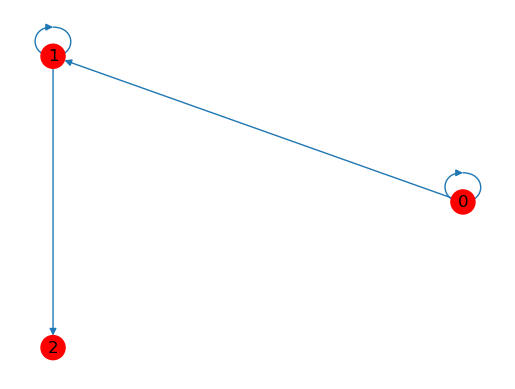

In [73]:
my_cell_pop.draw()

In [74]:
my_cell_pop.node_types

['gene']

In [75]:
my_cell_pop.edge_types

[('gene', 'regulates', 'gene')]

In [76]:
my_cell_pop['gene']

NodeSet(idx_low=0, idx_high=3, node attributes: ['name', 'dummy_value'])

In [77]:
my_cell_pop['gene', 'regulates', 'gene']

EdgeSet(4 edges, edge attributes: ['weight'])

In [78]:
my_cell_pop['gene', 'regulates', 'gene'].weight

tensor([[[ 0.0100],
         [-1.0000],
         [ 1.0000],
         [ 0.5000]]])

In [79]:
my_cell_pop['gene', 'regulates', 'gene'].weight.shape

torch.Size([1, 4, 1])

In [80]:
len(my_cell_pop['gene', 'regulates', 'gene'])

4

In [81]:
my_cell_pop['gene', 'regulates', 'gene'].element_level_attr_dict

{'weight': tensor([[[ 0.0100],
          [-1.0000],
          [ 1.0000],
          [ 0.5000]]])}

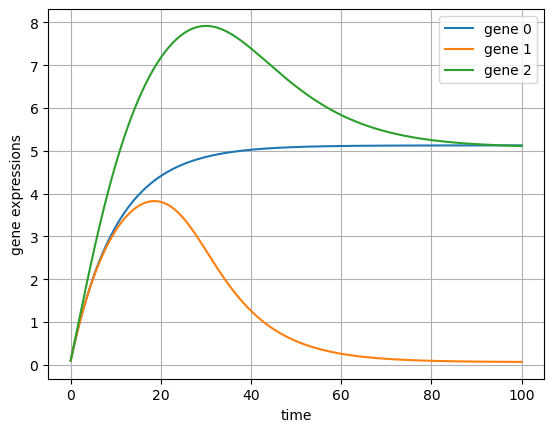

In [82]:
time_points = torch.linspace(0, 100, 1000)
cell_traj = simulate_deterministic_trajectory(my_cell_pop, time_points)
plot_trajectory(cell_traj, time_points)

## Intervention

In [83]:
from flecs.intervention import CrisprIntervention

In [84]:
crispr_intervention = CrisprIntervention(my_cell_pop)

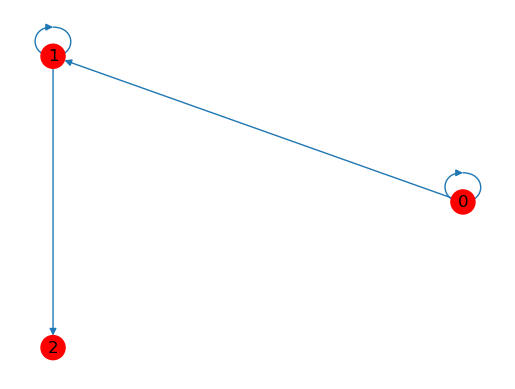

In [85]:
my_cell_pop.draw()

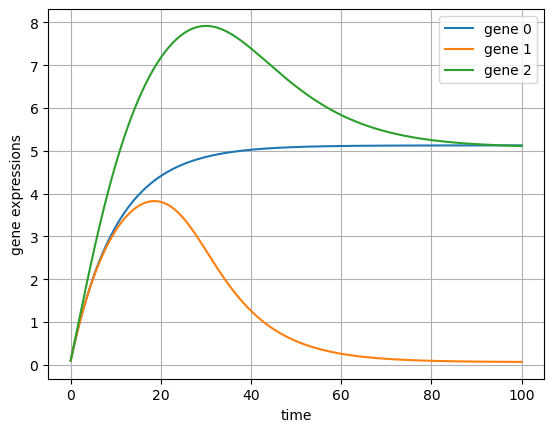

In [86]:
time_points = torch.linspace(0, 100, 1000)
my_cell_pop.reset_state()
cell_traj = simulate_deterministic_trajectory(my_cell_pop, time_points)
plot_trajectory(cell_traj, time_points)

In [87]:
crispr_intervention.intervene(0)

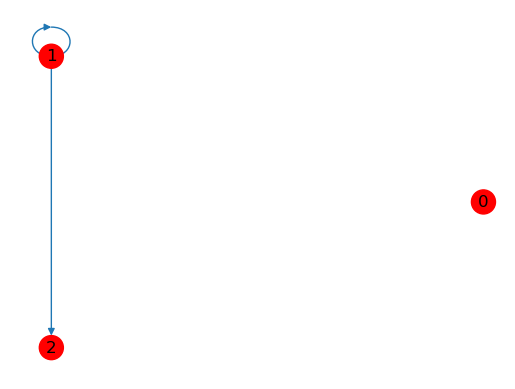

In [88]:
my_cell_pop.draw()

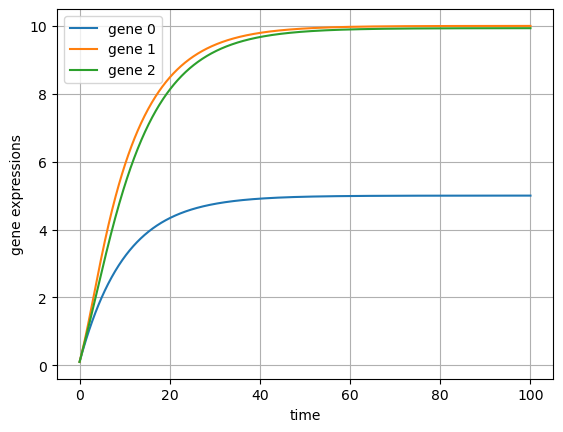

In [89]:
time_points = torch.linspace(0, 100, 1000)
my_cell_pop.reset_state()
cell_traj = simulate_deterministic_trajectory(my_cell_pop, time_points)
plot_trajectory(cell_traj, time_points)

In [90]:
crispr_intervention.reset()

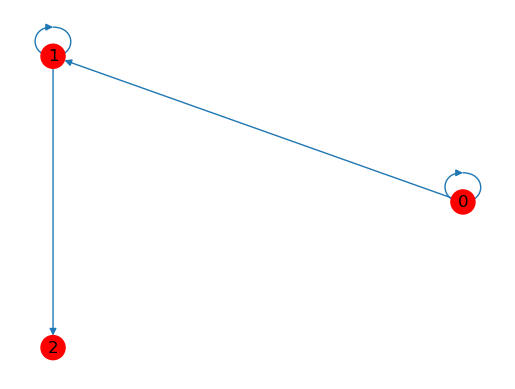

In [91]:
my_cell_pop.draw()

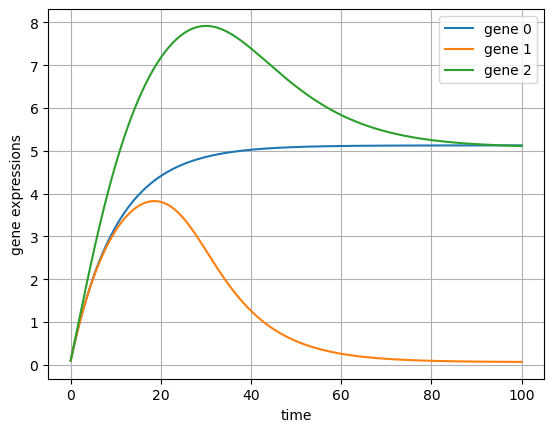

In [92]:
time_points = torch.linspace(0, 100, 1000)
my_cell_pop.reset_state()
cell_traj = simulate_deterministic_trajectory(my_cell_pop, time_points)
plot_trajectory(cell_traj, time_points)